In [37]:
from utils import setup_env_path

setup_env_path()

%load_ext autoreload
%autoreload 2

Former working directory:  /Users/ambroisebertin/Desktop/prog/prog_abeilles/fil-rouge-pollinisateurs
Current working directory:  /Users/ambroisebertin/Desktop/prog/prog_abeilles/fil-rouge-pollinisateurs
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import missingno as msno

In [39]:
API_keys = [
    "2b10Me1HF0rfjoGWCseolNa8e",
    "2b10Xs7brWPuBdRTSeWx9V7HJu",
    "2b10umm8L2jTYjlWrJKPfshJ0O",
    "2b10sEg5pSsrtVT372XqlrzcLe",
    "2b10LDWWlXJwuS6FleaqfK6Rke",
]

On a 500 requêtes PlantNet par clef API chaque jour.

## Préparation des données

In [40]:
# Import spipoll.csv as a pandas dataframe
spipoll = pd.read_csv("././data/spipoll.csv",low_memory=False)

# Extract relevant columns from the spipoll dataframe
plantes = spipoll[['collection_id', 'plante_sc', 'plante_fr',
       'plante_precision', 'plante_inconnue', 'plante_caractere',
       'photo_fleur', 'photo_plante', 'photo_feuille']]

# Shrinking the data by grouping by collection_id
# Keep only the first row for each unique value of collection_id
plantes = plantes.drop_duplicates(subset='collection_id', keep='first')

plantes.shape

(75372, 9)

In [41]:
values_to_check = ["Je ne sais pas", "Plante inconnue"]

In [42]:
plantes_sc_unlabelled = plantes.loc[ #renommer en plantes_unlabelled_sc pour plus de clarté ??
    (
        (plantes["plante_sc"].isna() | plantes["plante_sc"].isin(values_to_check))
    )
    | ((plantes["plante_inconnue"] == 1.0))
]

# creation du dataframe contenant les valeurs de plantes mais pas de plantes_sc_unlabelled
plantes_sc_labelled = plantes[~plantes.index.isin(plantes_sc_unlabelled.index)]

# in plante add "1" to the column group for each row that is in plantes_sc_labelled
plantes.loc[plantes_sc_labelled.index, 'group'] = 1

plantes_sc_labelled.shape

(63465, 9)

In [43]:
# verification des dimensions des deux df par rapport à la dim de plantes
plantes_sc_labelled.shape[0] + plantes_sc_unlabelled.shape[0] == plantes.shape[0]

True

Compression de l'information étiquettée redondante :

In [44]:
# group plantes_sc_labelled by unique values of plante_sc
plantes_sc_labelled = plantes_sc_labelled.drop_duplicates(subset='plante_sc', keep='first')

# display the dimension of the dataframe
plantes_sc_labelled.shape

(2620, 9)

On a donc un df avec 2620 plantes dont le nom est spécifié dans plante_sc et 11.907 (~1.8% des données d'origine, spipoll.csv) dont le nom n'est pas spécifié dans plante_sc.

In [45]:
# ajoute trois colonnes après plante_sc dans le dataframe plantes_sc_labelled "Famille", "Genre" et "Espèce" entre la colonne plante_sc et plante_fr
plantes_sc_labelled.insert(2, "Famille", np.nan)
plantes_sc_labelled.insert(3, "Genre", np.nan)
plantes_sc_labelled.insert(4, "Espece", np.nan)

# ajoute trois colonnes après plante_sc dans le dataframe plantes_sc_unlabelled "Famille", "Genre" et "Espèce" entre la colonne plante_sc et plante_fr
plantes_sc_unlabelled.insert(2, "Famille", np.nan)
plantes_sc_unlabelled.insert(3, "Genre", np.nan)
plantes_sc_unlabelled.insert(4, "Espece", np.nan)

In [46]:
plantes_sc_labelled.head()

,collection_id,plante_sc,Famille,Genre,Espece,plante_fr,plante_precision,plante_inconnue,plante_caractere,photo_fleur,photo_plante,photo_feuille
0,1,Les Trèfles à fleurs blanches ou roses en boul...,NaN,NaN,NaN,NaN,NaN,0.0,spontanée,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...
2,2,Acanthus mollis,NaN,NaN,NaN,Acanthe molle,NaN,NaN,plantée,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...
5,3,"Les Orchidées à fleurs blanches, jaunes ou ver...",NaN,NaN,NaN,NaN,orchis bouc - Himantoglossum hircinum,0.0,spontanée,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...
6,4,Les Vipérines à fleurs bleues-violacées (des e...,NaN,NaN,NaN,NaN,Theaceae,0.0,plantée,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...
10,5,Les Pâquerettes (Bellis sp),NaN,NaN,NaN,NaN,NaN,0.0,spontanée,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...


## Appel à l'API

In [107]:
from data_quality.plant_treatment.plantnet_api import PlantNetPredictor

def call_API(iloc, api_key_index=0):
    predictor = PlantNetPredictor(key = API_keys[api_key_index])
    prediction = None

    try:
        prediction = predictor.predict(imageURL= plantes_sc_labelled['photo_fleur'].iloc[iloc],
                        organs = "auto",
                        includeRelatedImages=False)
    except Exception :
        if api_key_index + 1 < len(API_keys):
            return call_API(iloc, api_key_index + 1)
        else:
            print("You used all your API keys for today.")
            return None

    famille = prediction["results"][0]["species"]["family"]["scientificNameWithoutAuthor"] # famille
    genre = prediction["results"][0]["species"]["genus"]["scientificNameWithoutAuthor"] # genre
    espece = prediction["results"][0]["species"]["scientificNameWithoutAuthor"] # espece

    return [famille, genre, espece]

In [84]:
def remplir_tableau(df, num):
    start_index = 0
    for i, val in enumerate(df["Famille"]):
        if pd.isnull(val):
            start_index = i
            break
    else:
        print("Le dataframe est déjà rempli à ces lignes.")
        return df

    for i in tqdm(range(start_index, start_index + num)):
        try:
            df.iloc[i, 2:5] = call_API(i)
        except Exception as e:
            print(f"Error: {e}")

    return df

### Un petit POC (pas nécessaire pour la suite)

In [85]:
remplir_tableau(plantes_sc_labelled, 7)

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:21<00:00,  3.14s/it]


,collection_id,plante_sc,Famille,Genre,Espece,plante_fr,plante_precision,plante_inconnue,plante_caractere,photo_fleur,photo_plante,photo_feuille
0,1,Les Trèfles à fleurs blanches ou roses en boul...,Fabaceae,Trifolium,Trifolium pratense,NaN,NaN,0.0,spontanée,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...
2,2,Acanthus mollis,Acanthaceae,Acanthus,Acanthus spinosus,Acanthe molle,NaN,NaN,plantée,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...
5,3,"Les Orchidées à fleurs blanches, jaunes ou ver...",Orchidaceae,Himantoglossum,Himantoglossum hircinum,NaN,orchis bouc - Himantoglossum hircinum,0.0,spontanée,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...
6,4,Les Vipérines à fleurs bleues-violacées (des e...,Theaceae,Camellia,Camellia sasanqua,NaN,Theaceae,0.0,plantée,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...
10,5,Les Pâquerettes (Bellis sp),Asteraceae,Bellis,Bellis sylvestris,NaN,NaN,0.0,spontanée,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...
...,...,...,...,...,...,...,...,...,...,...,...,...
665235,75 468,Arbutus andrachne,NaN,NaN,NaN,Arbousier de Chypre,NaN,0.0,spontanée,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...
665583,75 525,Pavonia hastata,NaN,NaN,NaN,Pavonie (Pavonia hastata),NaN,NaN,plantée,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...
665861,75 554,Medicago falcata,NaN,NaN,NaN,Luzerne en faucille,NaN,0.0,spontanée,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...
666544,75 625,Helianthus divaricatus,NaN,NaN,NaN,Hélianthe à feuilles Ètalées,NaN,NaN,spontanée,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...


In [86]:
plantes_sc_labelled.head(10) # verification des 7 premières lignes remplies et 3 suivantes non remplies

,collection_id,plante_sc,Famille,Genre,Espece,plante_fr,plante_precision,plante_inconnue,plante_caractere,photo_fleur,photo_plante,photo_feuille
0,1,Les Trèfles à fleurs blanches ou roses en boul...,Fabaceae,Trifolium,Trifolium pratense,NaN,NaN,0.0,spontanée,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...
2,2,Acanthus mollis,Acanthaceae,Acanthus,Acanthus spinosus,Acanthe molle,NaN,NaN,plantée,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...
5,3,"Les Orchidées à fleurs blanches, jaunes ou ver...",Orchidaceae,Himantoglossum,Himantoglossum hircinum,NaN,orchis bouc - Himantoglossum hircinum,0.0,spontanée,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...
6,4,Les Vipérines à fleurs bleues-violacées (des e...,Theaceae,Camellia,Camellia sasanqua,NaN,Theaceae,0.0,plantée,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...
10,5,Les Pâquerettes (Bellis sp),Asteraceae,Bellis,Bellis sylvestris,NaN,NaN,0.0,spontanée,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...
24,6,Les Bruyères à fleurs roses en grappes (des es...,Ericaceae,Erica,Erica x darleyensis,NaN,Bruyère carnée (Erica carnea),0.0,plantée,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...
25,7,Les Ajoncs (des espèces du genre Ulex),Fabaceae,Adenocarpus,Adenocarpus foliolosus,NaN,Ajonc (Ulex europaeus),0.0,ne se prononce pas,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...
41,12,Les Pissenlits (Taraxacum sp),Asteraceae,Taraxacum,Taraxacum palustre,NaN,Pissenlit (Taraxacum officinale),0.0,spontanée,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...
47,15,Les Crucifères jaunes (des espèces de la famil...,Brassicaceae,Sinapis,Sinapis arvensis,NaN,NaN,0.0,spontanée,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...
54,17,Senecio jacobaea,Asteraceae,Senecio,Senecio inaequidens,Le Sénéçon jacobée,NaN,0.0,spontanée,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...,https://spgp-api.65mo.fr/api/containers/spgp/d...


In [66]:
# (uniquement utile pour faire des tests) vide les colonnes "Famille", "Genre" et "Espece" du dataframe plantes_sc_labelled
plantes_sc_labelled.iloc[:, 2:5] = np.nan

In [89]:
plantes_sc_labelled.shape # verification du maintien de la dimension du dataframe : OK

(2620, 12)

## Pipeline

Il faut environ 3 secondes pour un call API, soit environ 2h10 pour les 2620 plantes à traiter dans plantes_sc_labelled.

On va donc stocker le dataframe dans un csv entre chaque appel à l'API pour ne pas perdre le travail effectué.

In [94]:
def save_dataframe(df, df_name):
    df.to_csv(f"data/temporary_data/plantes/{df_name}.csv", index=False)

In [ ]:
# ATTENTION : NE PAS EXECUTER CETTE CELLULE SI LES FICHIERS EXISTENT DEJA, SINON ILS SERONT ECRASES !!!

# (initialisation) stocke plante_sc_labelled et plante_sc_unlabelled dans deux fichiers csv
# save_dataframe(plantes_sc_labelled, "plantes_sc_labelled")
# save_dataframe(plantes_sc_unlabelled, "plantes_sc_unlabelled")

In [116]:
def pipeline_remplissage(df_name, num):
    df = pd.read_csv(f"data/temporary_data/plantes/{df_name}.csv")
    remplir_tableau(df, num)
    save_dataframe(df, df_name)

In [117]:
def verification_progression(df_name):
    # importe le dataframe plantes_sc_labelled depuis le fichier csv
    df = pd.read_csv(f"data/temporary_data/plantes/{df_name}.csv")
    # utilise missingno pour visualiser les valeurs manquantes dans le dataframe
    msno.matrix(df)

In [120]:
pipeline_remplissage('plantes_sc_labelled', 100)

  1%|          | 1/100 [00:01<02:49,  1.71s/it]

Error: list index out of range


 34%|███▍      | 34/100 [01:44<03:52,  3.53s/it]

You used all your API keys for today.


100%|██████████| 100/100 [05:17<00:00,  3.18s/it]


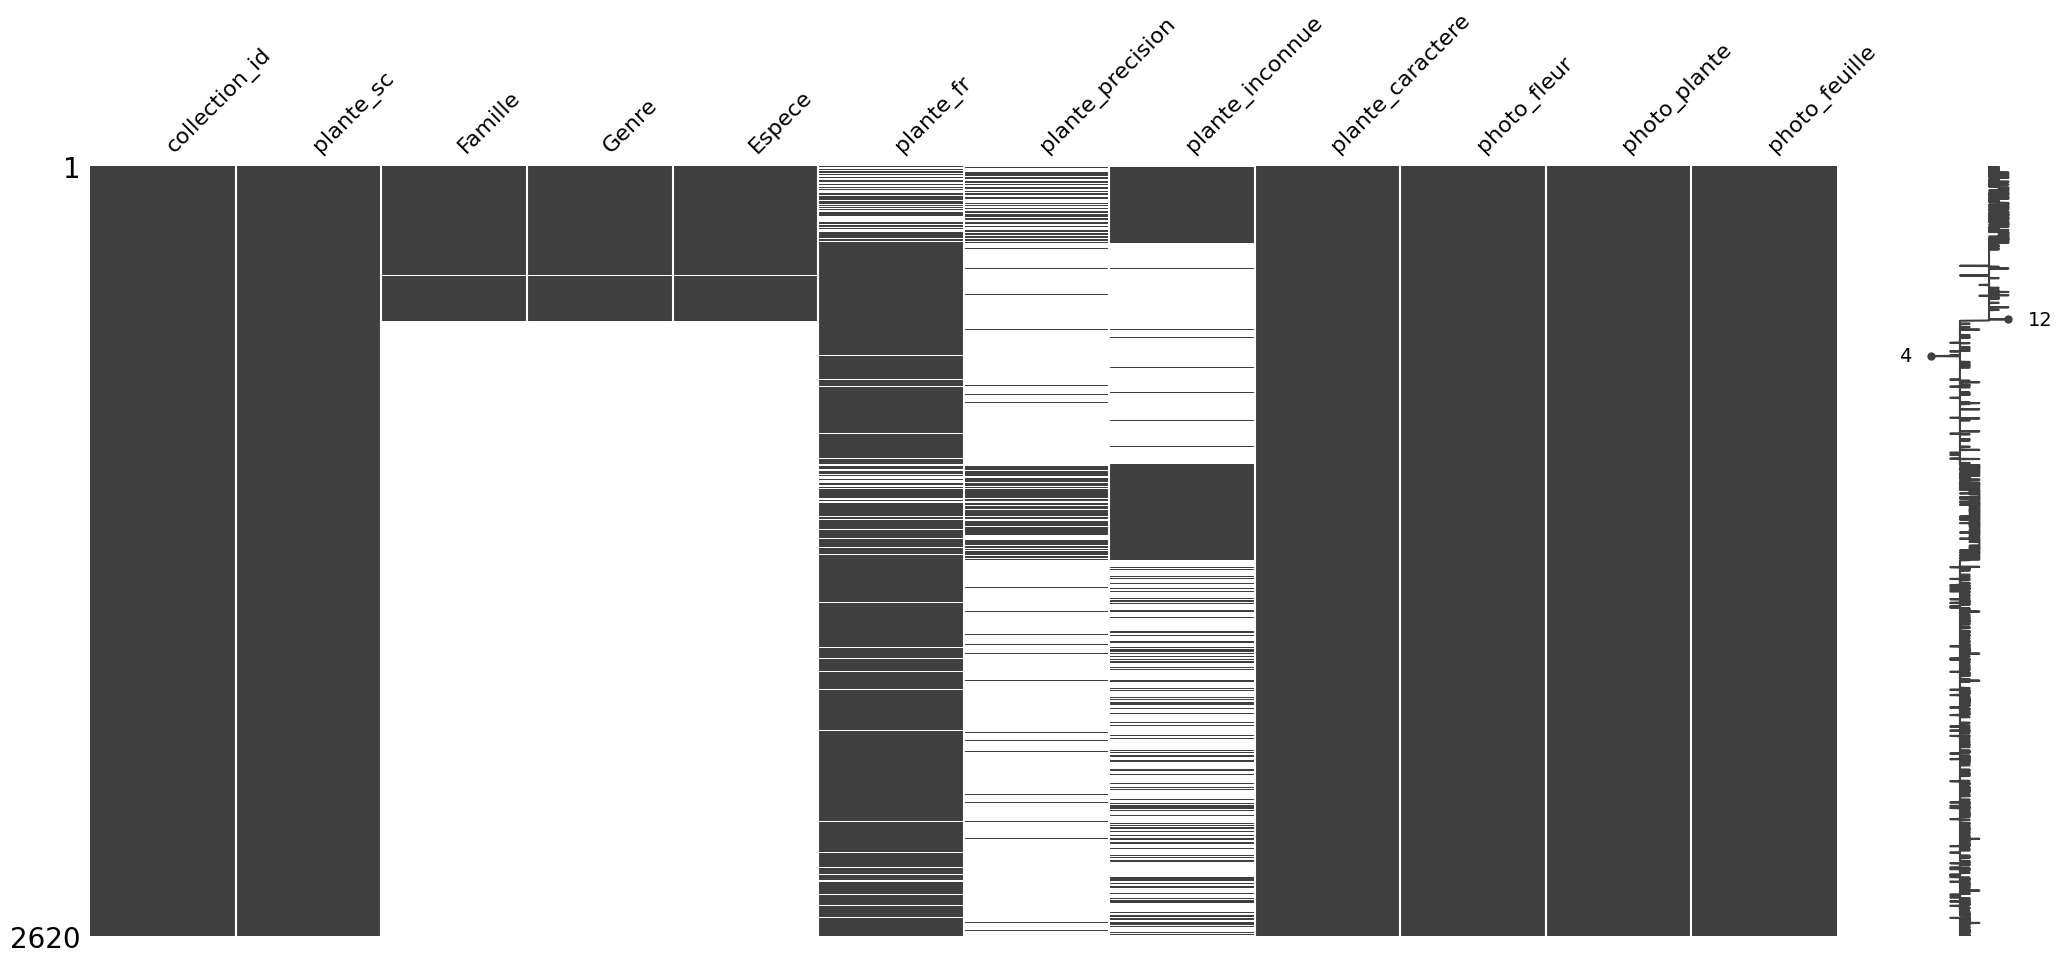

In [122]:
verification_progression('plantes_sc_labelled')